In [1]:
import os
import shutil
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
import random
import json
from google.colab import files
SEED = 900729
dir_path = './data'
train_path = './data/Training'
test_path = './data/Testing'
uploaded=files.upload()


Saving kaggle.json to kaggle.json


In [2]:
!ls
with open("kaggle.json") as f:
    kaggle_creds = json.load(f)

username = kaggle_creds["username"]
key = kaggle_creds["key"]

os.environ['KAGGLE_USERNAME'] = username
os.environ['KAGGLE_KEY'] = key

kaggle.json  sample_data


In [3]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()


In [4]:
api.dataset_download_files("masoudnickparvar/brain-tumor-mri-dataset", path="./data", unzip=True)


Dataset URL: https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset


In [5]:
def train_df(tr_path):
    classes, class_paths = zip(*[(label, os.path.join(tr_path, label, image))
                                 for label in os.listdir(tr_path) if os.path.isdir(os.path.join(tr_path, label))
                                 for image in os.listdir(os.path.join(tr_path, label))])

    tr_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return tr_df

In [6]:
def test_df(ts_path):
    classes, class_paths = zip(*[(label, os.path.join(ts_path, label, image))
                                 for label in os.listdir(ts_path) if os.path.isdir(os.path.join(ts_path, label))
                                 for image in os.listdir(os.path.join(ts_path, label))])

    ts_df = pd.DataFrame({'Class Path': class_paths, 'Class': classes})
    return ts_df

In [7]:
tr_orginal_df = train_df(train_path)
ts_orginal_df = test_df(test_path)
ts_orginal_df


,Class Path,Class
0,./data/Testing/meningioma/Te-me_0156.jpg,meningioma
1,./data/Testing/meningioma/Te-me_0026.jpg,meningioma
2,./data/Testing/meningioma/Te-me_0094.jpg,meningioma
3,./data/Testing/meningioma/Te-me_0075.jpg,meningioma
4,./data/Testing/meningioma/Te-me_0167.jpg,meningioma
...,...,...
1306,./data/Testing/glioma/Te-gl_0108.jpg,glioma
1307,./data/Testing/glioma/Te-gl_0024.jpg,glioma
1308,./data/Testing/glioma/Te-glTr_0007.jpg,glioma
1309,./data/Testing/glioma/Te-gl_0235.jpg,glioma


In [8]:
tr_orginal_df

,Class Path,Class
0,./data/Training/meningioma/Tr-me_0322.jpg,meningioma
1,./data/Training/meningioma/Tr-me_1304.jpg,meningioma
2,./data/Training/meningioma/Tr-me_0840.jpg,meningioma
3,./data/Training/meningioma/Tr-me_1295.jpg,meningioma
4,./data/Training/meningioma/Tr-me_0451.jpg,meningioma
...,...,...
5707,./data/Training/glioma/Tr-gl_0171.jpg,glioma
5708,./data/Training/glioma/Tr-gl_1118.jpg,glioma
5709,./data/Training/glioma/Tr-gl_0329.jpg,glioma
5710,./data/Training/glioma/Tr-gl_0592.jpg,glioma


In [9]:
val_df, tr_df = train_test_split(tr_orginal_df, train_size=0.25, random_state=SEED, stratify=tr_orginal_df['Class'])

validation_path = './data/Validation'
Path(validation_path).mkdir(exist_ok=True)

classes = ['glioma', 'meningioma', 'notumor', 'pituitary']
for class_name in classes:
    class_validation_path = Path(validation_path) / class_name
    class_validation_path.mkdir(exist_ok=True)

errors = []

for idx, row in val_df.iterrows():
    try:
        source_path = Path(row['Class Path'])

        filename = source_path.name
        class_name = row['Class']
        destination_path = Path(validation_path) / class_name / filename

        shutil.move(str(source_path), str(destination_path))

    except Exception as e:
        errors.append({
            'file': row['Class Path'],
            'class': row['Class'],
            'error': str(e)
        })


if errors:
    print(f"Errors: {len(errors)}")
    for error in errors:
        print(f"  - {error['class']}: {Path(error['file']).name} - {error['error']}")

val_df_updated = val_df.copy()
val_df_updated['Class Path'] = val_df_updated.apply(
    lambda row: str(Path(validation_path) / row['Class'] / Path(row['Class Path']).name),
    axis=1
)

tr_df_updated = train_df(train_path)

val_df = val_df_updated
tr_df = tr_df_updated

val_df

,Class Path,Class
312,data/Validation/meningioma/Tr-me_0680.jpg,meningioma
2060,data/Validation/notumor/Tr-no_1069.jpg,notumor
5526,data/Validation/glioma/Tr-glTr_0007.jpg,glioma
5546,data/Validation/glioma/Tr-gl_0105.jpg,glioma
4935,data/Validation/glioma/Tr-gl_1046.jpg,glioma
...,...,...
3281,data/Validation/pituitary/Tr-pi_0379.jpg,pituitary
847,data/Validation/meningioma/Tr-me_1066.jpg,meningioma
86,data/Validation/meningioma/Tr-me_0122.jpg,meningioma
1220,data/Validation/meningioma/Tr-me_1251.jpg,meningioma


In [10]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform_tr = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomRotation(degrees=20),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
transform_ts=transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])
transform_val =transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_dataset = datasets.ImageFolder(root=train_path, transform=transform_tr)
test_dataset  = datasets.ImageFolder(root=test_path, transform=transform_ts)
val_dataset   = datasets.ImageFolder(root=validation_path, transform=transform_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False)

print(train_dataset.classes)

['glioma', 'meningioma', 'notumor', 'pituitary']


In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class UNetClassifier(nn.Module):
    def __init__(self, in_channels=3, num_classes=4):
        super(UNetClassifier, self).__init__()

        # Encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.pool2 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = nn.Sequential(
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.7),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Dropout(0.7)
        )

        # Decoder
        self.up1 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec1 = nn.Sequential(
            nn.Conv2d(256, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.up2 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec2 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        # Classifier head
        self.gap = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(64, num_classes)

    def forward(self, x):
        # Encoder
        c1 = self.enc1(x)
        p1 = self.pool1(c1)

        c2 = self.enc2(p1)
        p2 = self.pool2(c2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder
        u1 = self.up1(b)
        # interpolacja do wymiarów skip connection
        if u1.size()[2:] != c2.size()[2:]:
            u1 = F.interpolate(u1, size=c2.size()[2:], mode='bilinear', align_corners=False)
        d1 = self.dec1(torch.cat([u1, c2], dim=1))

        u2 = self.up2(d1)
        if u2.size()[2:] != c1.size()[2:]:
            u2 = F.interpolate(u2, size=c1.size()[2:], mode='bilinear', align_corners=False)
        d2 = self.dec2(torch.cat([u2, c1], dim=1))

        # Classification
        gap = self.gap(d2).view(d2.size(0), -1)
        out = self.fc(gap)
        return out

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNetClassifier(in_channels=3, num_classes=4).to(device)
best_loss = float('inf')
patience = 5
counter = 0

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
scheduler= optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
for epoch in range(30):
    model.train()
    running_loss = 0.0
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1, Loss: 1.1041
Epoch 2, Loss: 0.9852
Epoch 3, Loss: 0.9341
Epoch 4, Loss: 0.8790
Epoch 5, Loss: 0.8495
Epoch 6, Loss: 0.8129
Epoch 7, Loss: 0.7590
Epoch 8, Loss: 0.7338
Epoch 9, Loss: 0.6878
Epoch 10, Loss: 0.6659
Epoch 11, Loss: 0.6498
Epoch 12, Loss: 0.6085
Epoch 13, Loss: 0.6211
Epoch 14, Loss: 0.5918
Epoch 15, Loss: 0.5683
Epoch 16, Loss: 0.5522
Epoch 17, Loss: 0.5464
Epoch 18, Loss: 0.5322
Epoch 19, Loss: 0.5181
Epoch 20, Loss: 0.4878
Epoch 21, Loss: 0.4794
Epoch 22, Loss: 0.4804
Epoch 23, Loss: 0.4609
Epoch 24, Loss: 0.4564
Epoch 25, Loss: 0.4480
Epoch 26, Loss: 0.4271
Epoch 27, Loss: 0.4137
Epoch 28, Loss: 0.4038
Epoch 29, Loss: 0.4007
Epoch 30, Loss: 0.4023


In [16]:
model.eval()
val_loss = 0.0
with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

val_loss /= len(val_loader)
if val_loss < best_loss:
    best_loss = val_loss
    counter = 0
    torch.save(model.state_dict(), 'best_model.pth')



Test Loss: 2.1915
Test Accuracy: 46.68%

Classification Report:
              precision    recall  f1-score   support

      glioma       0.00      0.00      0.00       300
  meningioma       0.00      0.00      0.00       306
     notumor       0.77      0.79      0.78       405
   pituitary       0.33      0.98      0.49       300

    accuracy                           0.47      1311
   macro avg       0.27      0.44      0.32      1311
weighted avg       0.31      0.47      0.35      1311


Confusion Matrix:


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


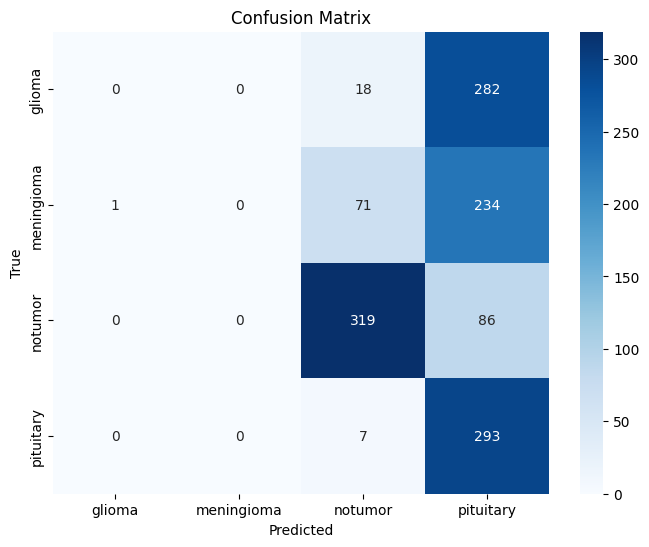

In [17]:
model.load_state_dict(torch.load('best_model.pth'))

model.eval()
test_loss = 0.0
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_loss /= len(test_loader)
accuracy = 100 * correct / total

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")


print("\nClassification Report:")
print(classification_report(all_labels, all_predictions, target_names=test_dataset.classes))

print("\nConfusion Matrix:")
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_dataset.classes, yticklabels=test_dataset.classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()